# Automatyczna klasyfikacja terenu z wykorzystaniem uczenia maszynowego

Zrodlo danych: Sentinel T34UDE_20200815T095039
Kroki wykonane przed analizą:
* Zmiana formatu warstw z jp2 na png ze względu na bezproblemową współpracę z OpenCV
* Klasyfikacja terenu z QGIS oraz wtyczkę QuickOSM
 ** water
 ** forest
 ** farmland
* Dla każdego typu terenu utworzono maskę w formie obrazu PNG o rozdzielczości zgodnej z danymi wejściowymi
* Utworzenie pliku konfiguracyjnego config.ini

#### Wczytanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

from configparser import ConfigParser
from time import time

In [2]:
import preprocesing as pre
import helpers as hlp

#### Wczytanie danyc z pliku konfiguracyjnego

In [3]:
config = ConfigParser()
config.read('config.ini')
input_dir = config['main']['input_dir']# Folder ze zdjęciami z Sentinela
classes_file = config['main']['classification_data']# Folder z maskami klas

Zdjęcia o rozdzielczości 10m składają sie z ponad 100 milionów pikseli
zatem do analizy wykorzystam tylko jego fragment o rozmiarze dx na dy
i zaczynający się od piksela (x_star, y_start)

In [4]:
dx = int(config['main']['x_size'])
dy = int(config['main']['y_size'])
x_start = int(config['main']['x_start'])
y_start = int(config['main']['y_start'])
csv_data_file = config['main']['csv_data_file']

#### Przekształcamy dane wejściowe w coś przyjemniejszego do analizy

In [5]:
data, columns_names = pre.images_to_numpy(input_dir, dx, dy, x_start, y_start)

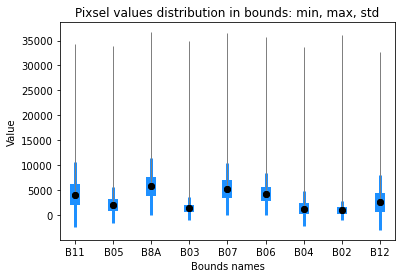

In [6]:
hlp.plot_MinMaxAvg(data, columns_names)

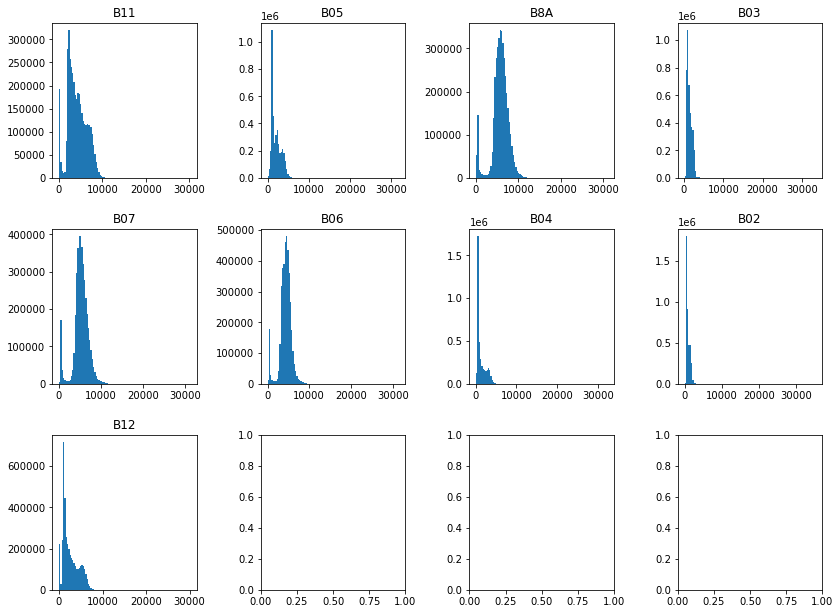

In [7]:
hlp.plot_values_histogram(data, columns_names, ncols=4)

Rozkład wartości pikseli wskazuje na występowanie wartości odstających zatem przekształćmy je w następujący sposób: $ x = min(x,\overline{x}+3\sigma_{x}) $ oraz przeskalujmy z wykorzystaniem minmaxscaler z sklearn.

In [8]:
data = pre.remove_outstandings(data)
sc = MinMaxScaler(feature_range=(0, 1))
data = sc.fit_transform(data)

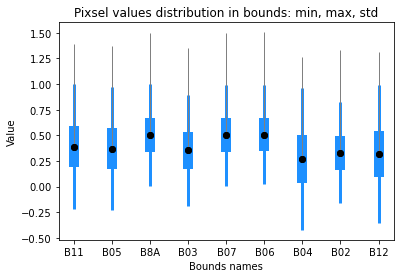

In [9]:
hlp.plot_MinMaxAvg(data, columns_names)

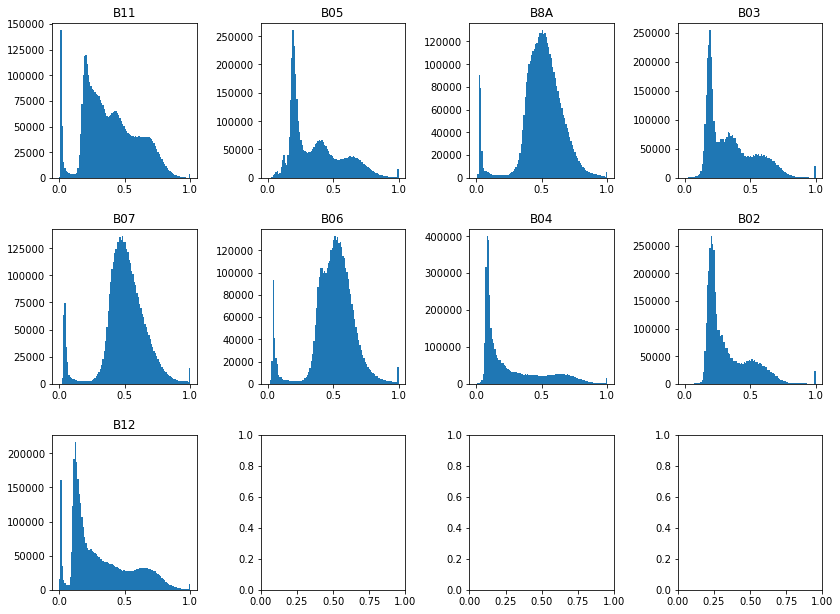

In [10]:
hlp.plot_values_histogram(data, columns_names, ncols=4)

#### Wczytajmy teraz maski klas oraz stwórzmy klasę "other"

In [11]:
classes, classes_names = pre.get_classes(classes_file, dx, dy, x_start, y_start)
other = (1 - classes.any(axis=1).astype(int)).reshape(-1, 1)
classes_names += ['other']
pre.add_classes_to_config(config, classes_names)
columns_names += classes_names 
nr_of_classes = len(classes_names)

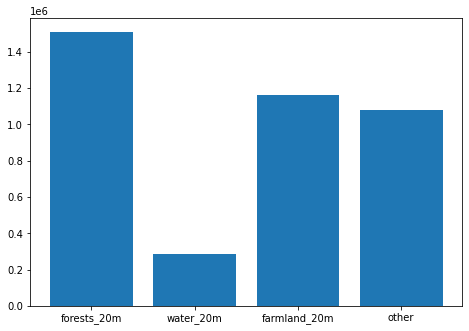

In [12]:
hlp.show_classes_distribution(np.concatenate((classes, other), axis=1), classes_names)

#### Łączymy wszystko

In [13]:
data = np.concatenate((data, classes, other), axis=1)
data = pd.DataFrame(data, columns=columns_names)
data[classes_names] = data[classes_names].astype('int')

In [14]:
data.head()

,B11,B05,B8A,B03,B07,B06,B04,B02,B12,forests_20m,water_20m,farmland_20m,other
0,0.433658,0.398199,0.672481,0.383684,0.689333,0.685476,0.203127,0.328385,0.308364,0,0,0,1
1,0.431770,0.389490,0.665015,0.381972,0.683049,0.686180,0.204827,0.335269,0.304388,0,0,0,1
2,0.425162,0.381825,0.689844,0.379117,0.705519,0.711768,0.193778,0.327696,0.295691,0,0,0,1
3,0.421575,0.366148,0.710854,0.360846,0.736368,0.714820,0.171681,0.316681,0.289976,0,0,0,1
4,0.428183,0.377645,0.690018,0.380830,0.711422,0.703552,0.192078,0.320812,0.295691,0,0,0,1


#### Dane zostały przygotowane zapisujemy je i możemy zająć się klasyfikacją

In [15]:
data.to_csv(csv_data_file)

#### Dzielimy dane

In [16]:
X = data.iloc[:,:-nr_of_classes].to_numpy()
Y = data.iloc[:,-nr_of_classes:].to_numpy()
xyz = (dx,dy,nr_of_classes)

Zwalniamy trochę pamięci

In [18]:
del data
del classes
del other

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

# Klasyfikacja obszaru z wykorzystaniem lasów losowych

#### Trenowanie

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
tic = time()
clf.fit(X_train, Y_train)
time_RF = time() - tic

#### Testowanie

In [21]:
Y_pred_RF = clf.predict(X_test)

In [22]:
print("Random forest acc: ",accuracy_score(Y_test, Y_pred_RF))

Random forest acc:  0.8278766666666667


#### Wizualizacja wyników

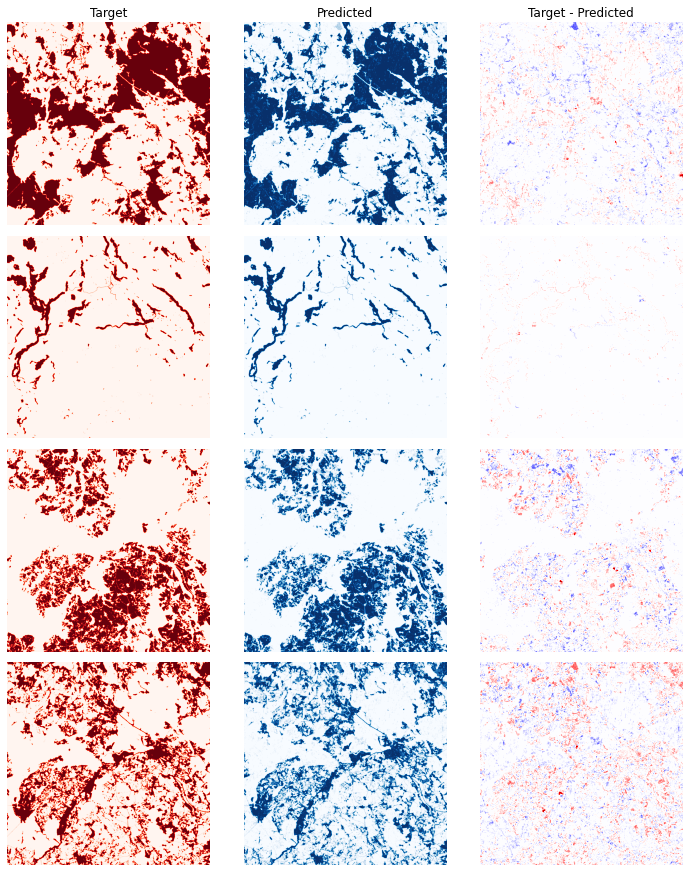

In [23]:
Y_pred_RF = clf.predict(X)
Y_pred_RF = np.rint(Y_pred_RF)
hlp.show_target_pred_dif(Y.reshape(xyz), Y_pred_RF.reshape((dx, dy, nr_of_classes)))

# Klasyfikacja obszaru z wykorzystaniem sieci neuronowych

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

#### Przygotowujemy model

In [25]:
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [26]:
#### TODO dodanie warstwy conwoluacyjnej powinno poprawić skuteczność. 

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1280      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 2

In [28]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Trenujemy

In [29]:
tic = time()
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), shuffle = 'True', epochs=50, batch_size=100000)

Epoch 1/50
28/28 [==============================] - 2s 80ms/step - loss: 0.4316 - accuracy: 0.5562 - val_loss: 0.3247 - val_accuracy: 0.7349
Epoch 2/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2955 - accuracy: 0.7551 - val_loss: 0.2569 - val_accuracy: 0.7812
Epoch 3/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2596 - accuracy: 0.7835 - val_loss: 0.2460 - val_accuracy: 0.7940
Epoch 4/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2493 - accuracy: 0.7948 - val_loss: 0.2377 - val_accuracy: 0.8053
Epoch 5/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2419 - accuracy: 0.8035 - val_loss: 0.2310 - val_accuracy: 0.8118
Epoch 6/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2358 - accuracy: 0.8110 - val_loss: 0.2255 - val_accuracy: 0.8185
Epoch 7/50
28/28 [==============================] - 2s 75ms/step - loss: 0.2310 - accuracy: 0.8161 - val_loss: 0.2210 - val_accuracy: 0.8220
Epoch 8/50
28

In [30]:
time_DL = time()-tic

In [31]:
_, accuracy = model.evaluate(X_test, Y_test)
print(f'Deap learning acc: {accuracy}')

37500/37500 [==============================] - 44s 1ms/step - loss: 0.1964 - accuracy: 0.8389
Deap learning acc: 0.8389049768447876


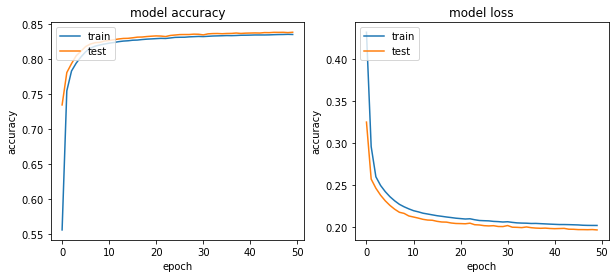

In [32]:
hlp.plot_keras_history(history)

Dokładność na danych testowych jest wyższa niż na danych uczących ze względu na błędy w ręcznej klasyfikacji

#### Wizualizacja wyników

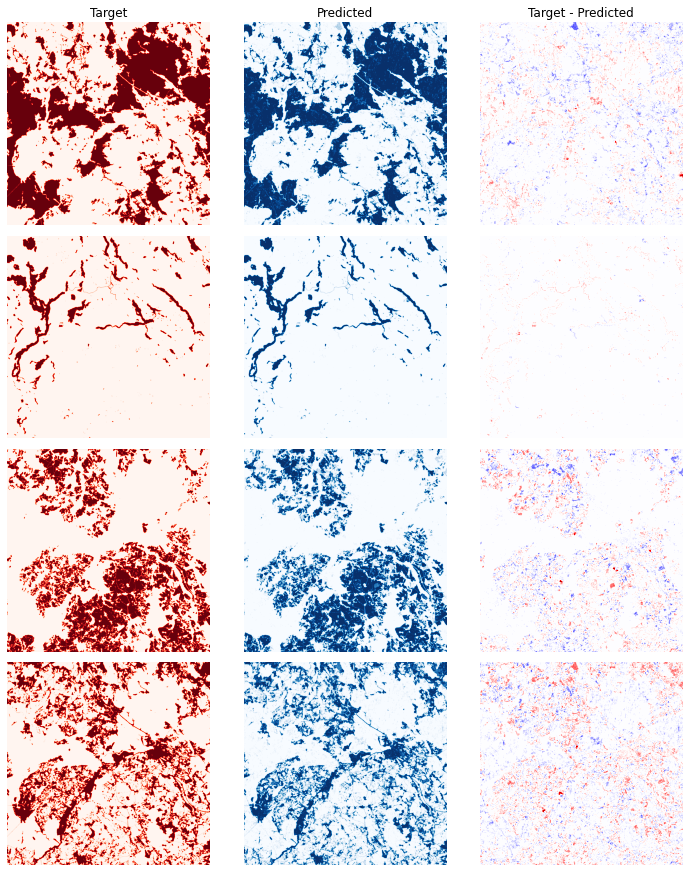

In [33]:
Y_pred_DL = model.predict(X)
Y_pred_DL = np.rint(Y_pred_DL)
hlp.show_target_pred_dif(Y.reshape(xyz), Y_pred_RF.reshape((dx, dy, nr_of_classes)))

# Klasyfikacja obszaru z wykorzystaniem samoorganizujących się map

In [34]:
from minisom import MiniSom
x_som, y_som = 4,4
som = MiniSom(x=x_som, y=y_som, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X)
som.train_random(X, num_iteration=100000, verbose=False)

#### Klasyfikujemy
Każdemu punktowi możemy przypisać jeden z neuronów mapy

In [35]:
Y_pred_SOM = [som.winner(x) for x in X]
Y_pred_SOM = np.array([str(i) for i in Y_pred_SOM ])

#### One Hot Encode

In [36]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
Y_pred_SOM = enc.fit_transform(Y_pred_SOM.reshape(-1, 1)).toarray()

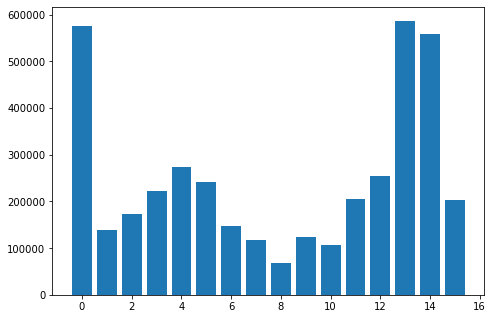

In [37]:
hlp.show_classes_distribution(Y_pred_SOM, list(range(Y_pred_SOM.shape[1])))

In [38]:
mapa = np.sum(Y_pred_SOM*som.distance_map().flatten(), axis=1)

#### rysujemy mapę

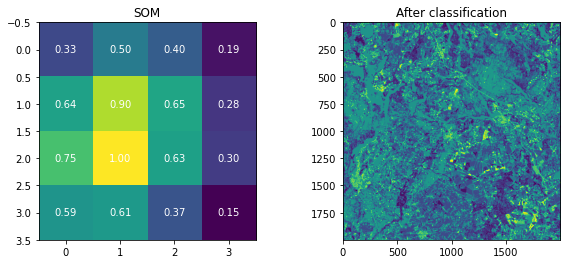

In [39]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2, nrows=1)
ax1.set_title('SOM')
ax1.imshow(som.distance_map())
for (i, j), z in np.ndenumerate(som.distance_map()):
    ax1.text(j, i, '{:0.2f}'.format(som.distance_map()[i,j]), ha='center', va='center',color = 'white')
ax2.set_title('After classification')
ax2.imshow(mapa.reshape((dx,dy)))

In [40]:
import cv2
cv2.imwrite('wynik_som.png', mapa.reshape((dx,dy))*255)

True

#### Walidacja

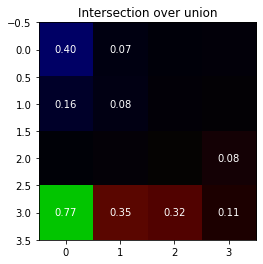

In [41]:
clusstered = np.zeros((x_som,y_som,3))
matrix_IoU = hlp.metrics_matrix(Y, Y_pred_SOM, hlp.IoU)
clusstered[...,2]=matrix_IoU[:,2].reshape((x_som,y_som))#Klasa 1 kolor niebieski
clusstered[...,1]=matrix_IoU[:,1].reshape((x_som,y_som))#Klasa 2 kolor zielony
clusstered[...,0]=matrix_IoU[:,0].reshape((x_som,y_som))#Klasa 3 kolor czerwony
fig, ax = plt.subplots()
ax.set_title('Intersection over union')
plt.imshow(clusstered)
for (i, j, k), z in np.ndenumerate(clusstered):
    if z > 0.05:
        ax.text(j, i, '{:0.2f}'.format(max(clusstered[i,j,:])), ha='center', va='center',color = 'white')

Kolorami oznaczono klasę którą reprezentują. Słabe wyniki spowodowane są dużo wyższą liczbą otrzymanych klas niż klas które mieliśmy początkowo.

In [42]:
best = [matrix_IoU[:,i].argsort()[-1] for i in range(3)]

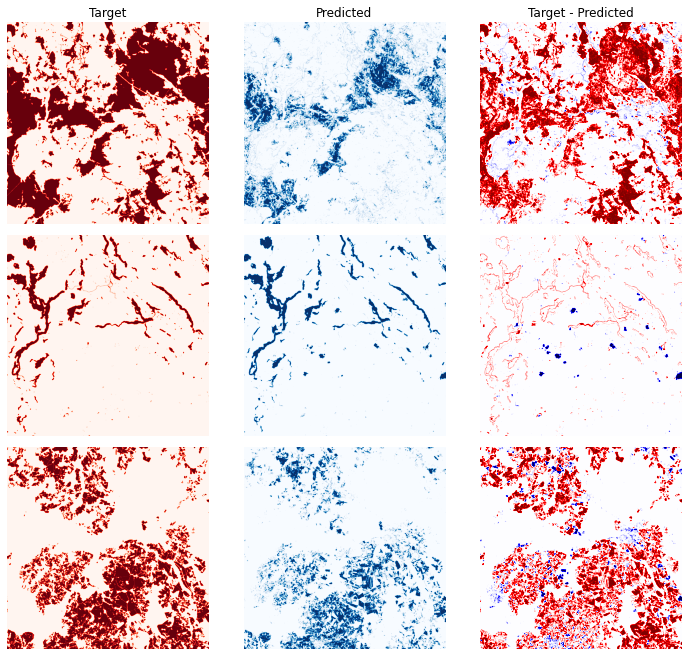

In [43]:
hlp.show_target_pred_dif(Y.reshape(xyz)[...,:-1], Y_pred_SOM.reshape((dx,dy,Y_pred_SOM.shape[1]))[...,best])

In [44]:
yt, yp = Y.reshape(xyz)[...,1],  Y_pred_RF.reshape(xyz)[...,1]
cv2.imwrite('RF.png',(yt-yp+1)*127)

True

In [45]:
yt, yp = Y.reshape(xyz)[...,1],  Y_pred_DL.reshape(xyz)[...,1]
cv2.imwrite('DL.png',(yt-yp+1)*127)

True

# Walidacja:

Jako miarę poprawności algorytmu wybrałem 
Indeks Jaccarda w skrócie IoU
$$IoU = \frac{A \cap B}{A \cup B} $$
Dodatkowo wyznaczyłem dokładność(acc) i precyzję(prec) 

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [47]:
IoU_DL = [hlp.IoU(Y[...,i],Y_pred_DL[...,i]) for i in range(4)]

In [48]:
IoU_RF = [hlp.IoU(Y[...,i],Y_pred_RF[...,i]) for i in range(4)]

In [49]:
cm_DL = confusion_matrix(Y.argmax(axis=1), Y_pred_DL.argmax(axis=1))
cm_RF = confusion_matrix(Y.argmax(axis=1), Y_pred_RF.argmax(axis=1))

In [50]:
validation = pd.DataFrame(columns=['model'] + classes_names)

In [51]:
validation.loc[0]=(['IoU_DL']+IoU_DL)
validation.loc[1]=(['IoU_RF']+IoU_RF)
validation.loc[2]=(['Acc_DL']+hlp.acc(cm_DL))
validation.loc[3]=(['Acc_RF']+hlp.acc(cm_RF))
validation.loc[4]=(['Prec_DL']+hlp.prec(cm_DL))
validation.loc[5]=(['Prec_RF']+hlp.prec(cm_RF))
validation

,model,forests_20m,water_20m,farmland_20m,other
0,IoU_DL,0.832639,0.871005,0.719903,0.550991
1,IoU_RF,0.948904,0.964387,0.911515,0.849597
2,Acc_DL,0.918894,0.990103,0.908303,0.851247
3,Acc_RF,0.975302,0.997676,0.973755,0.956838
4,Prec_DL,0.865087,0.916879,0.844960,0.748275
5,Prec_RF,0.955033,0.984829,0.955728,0.934485


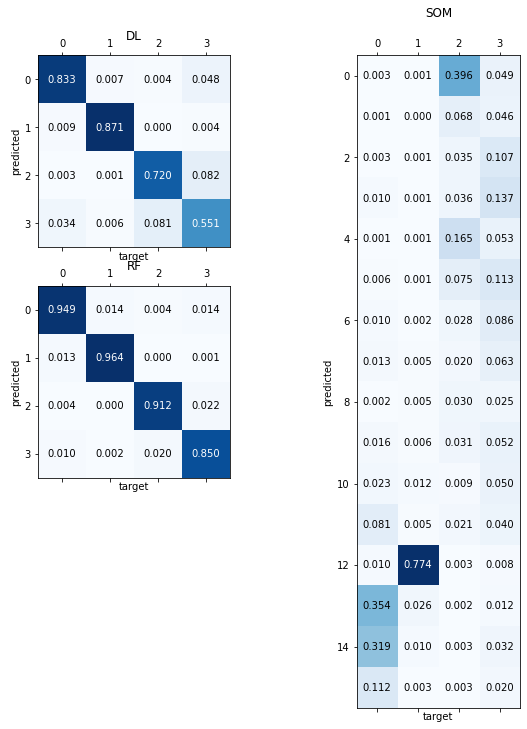

In [52]:
models_names = ['DL','RF', 'SOM']
colors = ['black', 'white']
fig = plt.figure(figsize=(10,12))
gs = fig.add_gridspec(3,2)
axs = []
axs.append(fig.add_subplot(gs[0, 0]))
axs.append(fig.add_subplot(gs[1, 0]))
axs.append(fig.add_subplot(gs[:, 1]))
axs.append(fig.add_subplot(gs[2, 0]))
axs[-1].axis('off')

for k, y in enumerate([Y_pred_DL, Y_pred_RF, Y_pred_SOM]):
    cm = hlp.metrics_matrix(Y,y)
    axs[k].matshow(cm, cmap='Blues')
    axs[k].set_title(models_names[k])
    axs[k].set(xlabel='target', ylabel='predicted')
    for (i, j), z in np.ndenumerate(cm):
            axs[k].text(j, i, '{:0.3f}'.format(z), ha='center', va='center',color = colors[int(round(z))])

TODO
* przenieść skrypt do helpers
* poprawić rozmieszczenie wykresów

#### Porównanie czasu uczenia modelów

In [53]:
print(f'Time RF: {time_RF:0.1f}s')
print(f'Time DL: {time_DL:0.1f}s')

Time RF: 1408.3s
Time DL: 110.6s


# Prezentacja wyników

TODO Poprawić 

In [54]:
X_valid , columns_names = pre.images_to_numpy(input_dir, dx, dy, 2500, 2500)
X_valid = pre.remove_outstandings(X_valid)
X_valid = sc.fit_transform(X_valid)

#scaller powinien być zapisany gdzieś by można było go potem wykorzystać

In [55]:
Y_valid , classes_names = pre.get_classes(classes_file, dx, dy, 2500, 2500)

In [56]:
Y_valid_pred = clf.predict(X_valid)

In [57]:
Y_valid_pred_DL = model.predict(X_valid)

In [58]:
Y_valid_pred = np.rint(Y_valid_pred)

In [59]:
Y_valid_pred_DL = np.rint(Y_valid_pred_DL)

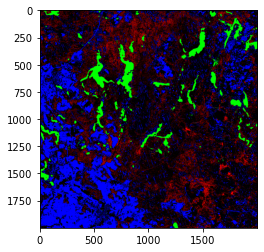

In [60]:
plt.imshow(Y_valid_pred_DL[:,:3].reshape((dx,dy,3)))

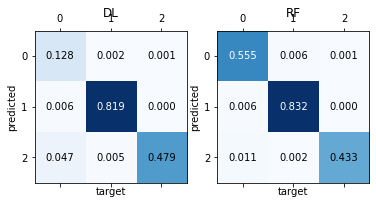

In [61]:
models_names = ['DL','RF', 'SOM']
colors = ['black', 'white']
fig, axs = plt.subplots(ncols=2, nrows=1)

for k, y in enumerate([Y_valid_pred_DL[:,:3], Y_valid_pred[:,:3]]):
    cm = hlp.metrics_matrix(Y_valid,y)
    axs[k].matshow(cm, cmap='Blues')
    axs[k].set_title(models_names[k])
    axs[k].set(xlabel='target', ylabel='predicted')
    for (i, j), z in np.ndenumerate(cm):
            axs[k].text(j, i, '{:0.3f}'.format(z), ha='center', va='center',color = colors[int(round(z))])

# Wnioski

* Random Forest najwolniejszy ale najlepsze wyniki
* Deap Learning szybszy należałoby poprawić architekturę. Więcej warstw, większe warstwy?
* SOM z wykrywaniem wody poradził sobie całkiem dobrze. Lasy przypisał głównie do 3 kategorii, pola i inne wygrały w pozostałych klasach. Oznacza to, iż wody są mniejwięcej jednorodne natowast pozostałe klasy przy próbach klasyfikacj wypadałoby podzielić na podklasy
#### Dokładność
* niska dokładność na danych testowych i wysoka na uczących może oznaczać mocne przeuczenie modeli, z drugiej strony może oznaczać, że rodzaj terenu na obszaże walidacyjnym był różny od tego z obszaru uczącego. 
#### Do czego to może się przydać? 
* DL/RF do weryfikacji klasyfikacji pozyskanej z zewnętrzych źródeł
* SOM do tego do czego został stworzony czyli wyszukiwania podklas